In [166]:
import pandas as pd
import numpy as np
import datetime as dt
import datetime
from datetime import datetime, timedelta, date
import pickle
import warnings

#settings
warnings.filterwarnings("ignore")

appearances_df = pd.read_csv("../raw_data/appearances.csv")
clubs_df = pd.read_csv("../raw_data/clubs.csv")
games_df = pd.read_csv("../raw_data/games.csv")
players_df = pd.read_csv("../raw_data/players.csv")



def players_df_preproc(players_df):
    #add year to game valuations
    now = datetime.now()
    players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
    players_df = players_df[players_df['date_of_birth'].isnull() == False]
    players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
    players_df['age'] = players_df['age'].round().astype(int) 

    # Calculate the contract remaining of each player
    players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])
    players_df = players_df[players_df['contract_expiration_date'].isnull() == False]
    players_df['term_days_remaining'] = (players_df['contract_expiration_date']- now).apply(lambda x: x.days) 
    return players_df

def appearances_df_preproc(appearances_df):
    # add year to player appearances
    appearances_df['datetime']=pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
    appearances_df['year']=appearances_df['datetime'].dt.year
    appearances_df = appearances_df[(appearances_df.year > 2004 ) & (appearances_df.year < 2023 )]
    return appearances_df
"""
def games_and_appearances_df_preproc(games_df,appearances_df):
    games_df['datetime']=pd.to_datetime(games_df['date'], format="%Y-%m-%d")
    games_df['year']=games_df['datetime'].dt.year
    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]
    games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
    return games_and_appearances_df

def feature_encode(df,column):
    dummies=pd.get_dummies(df[column], prefix_sep='_') 
    df = pd.concat([df, dummies], axis=1)
    return df
    """

'\ndef games_and_appearances_df_preproc(games_df,appearances_df):\n    games_df[\'datetime\']=pd.to_datetime(games_df[\'date\'], format="%Y-%m-%d")\n    games_df[\'year\']=games_df[\'datetime\'].dt.year\n    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]\n    games_and_appearances_df = appearances_df.merge(games_df, on=[\'game_id\'], how=\'left\')\n    return games_and_appearances_df\n\ndef feature_encode(df,column):\n    dummies=pd.get_dummies(df[column], prefix_sep=\'_\') \n    df = pd.concat([df, dummies], axis=1)\n    return df\n    '

In [167]:
clubs_df['total_market_value'].isnull().sum()
clubs_df.dropna(subset=['total_market_value'])

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,url
0,1032,fc-reading,Fc Reading,GB1,33.66,26,25.9,12,46.2,6,Select Car Leasing Stadium,24161,+£8.37m,Brian McDermott,https://www.transfermarkt.co.uk/fc-reading/sta...
2,1387,acn-siena-1904,Acn Siena 1904,IT1,4.32,30,26.2,6,20.0,2,Artemio Franchi,15373,£-6Th.,Serse Cosmi,https://www.transfermarkt.co.uk/acn-siena-1904...
3,1071,wigan-athletic,Wigan Athletic,GB1,12.38,29,26.5,14,48.3,6,DW Stadium,25133,£-140Th.,Roberto Martínez,https://www.transfermarkt.co.uk/wigan-athletic...
5,142,real-saragossa,Real Saragossa,ES1,22.86,24,26.6,5,20.8,0,La Romareda,33068,+-0,Manolo Jiménez,https://www.transfermarkt.co.uk/real-saragossa...
7,1436,sc-beira-mar,Sc Beira Mar,PO1,135.00,22,27.5,9,40.9,0,Estádio Mário Duarte,12000,+-0,Ulisses Morais,https://www.transfermarkt.co.uk/sc-beira-mar/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,3729,arsenal-tula,Arsenal Tula,RU1,15.37,25,28.2,6,24.0,3,Arsenal,19241,+£2.21m,Oleg Kononov,https://www.transfermarkt.co.uk/arsenal-tula/s...
166,2698,rubin-kazan,Rubin Kazan,RU1,24.35,22,25.0,4,18.2,4,Ak Bars Arena,45379,+£2.62m,Leonid Slutski,https://www.transfermarkt.co.uk/rubin-kazan/st...
167,28095,fk-ufa,Fk Ufa,RU1,15.35,24,26.6,7,29.2,2,BetBoom Arena,15132,+£419Th.,Sergey Tomarov,https://www.transfermarkt.co.uk/fk-ufa/startse...
168,40,fc-girondins-bordeaux,Fc Girondins Bordeaux,FR1,75.51,31,25.2,19,61.3,11,Matmut Atlantique,42052,+£7.47m,David Guion,https://www.transfermarkt.co.uk/fc-girondins-b...


In [168]:
def games_and_appearances_df_preproc(games_df,appearances_df,clubs_df):
    games_df['datetime']=pd.to_datetime(games_df['date'], format="%Y-%m-%d")
    games_df['year']=games_df['datetime'].dt.year
    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]
    games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
    
    # here we impute the missing values with the minimum value of the corresponding league 
    # get the minimum value of the 'Domestic League' column
    min_value = clubs_df.groupby('domestic_competition_id')['total_market_value'].min()
    
    # here we impute the missing values with the mean value of the corresponding league 
    # get the mean value of the 'Domestic League' column
    mean_value = clubs_df.groupby('domestic_competition_id')['total_market_value'].mean()
    
        
    # fill missing values in 'Market Value' column with the minimum value of the 'Domestic League' column
    # clubs_df['total_market_value'] = clubs_df.apply(lambda x: min_value[x['domestic_competition_id']] if pd.isnull(x['total_market_value']) else x['total_market_value'], axis=1)
    
    # fill missing values in 'Market Value' column with the mean value of the 'Domestic League' column
    #clubs_df['total_market_value'] = clubs_df.apply(lambda x: mean_value[x['domestic_competition_id']] if pd.isnull(x['total_market_value']) else x['total_market_value'], axis=1)
    
    
    table_df = games_and_appearances_df
    
    # Join the tables on the home and away club IDs
    table_df = table_df.merge(clubs_df[['club_id', 'total_market_value']], 
                            how='left', 
                            left_on='home_club_id', 
                            right_on='club_id')

    table_df = table_df.merge(clubs_df[['club_id', 'total_market_value']], 
                            how='left', 
                            left_on='away_club_id', 
                            right_on='club_id',
                            suffixes=('_home', '_away'))

    # Rename the columns to reflect the market value data
    table_df = table_df.rename(columns={'market_value_home': 'home_club_market_value',
                                        'market_value_away': 'away_club_market_value'})

    # Drop the redundant club_id columns
    table_df = table_df.drop(['club_id_home', 'club_id_away'], axis=1)
    
    games_and_appearances_df = table_df
    
    games_and_appearances_df.dropna(inplace=True)
    
    
    return games_and_appearances_df

In [169]:
def player_stats(player_id, season, games_and_appearances_df):
    #create a function to collate player stats
    df = games_and_appearances_df[games_and_appearances_df['player_id'] == player_id]
    df =  df[df['season'] == season]    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for',
                                                     'goals_against','clean_sheet',
                                                     'yellow_cards', 'red_cards','value_goals_for','value_goals_against','value_clean_sheet'])
        return out_df    
    else:       
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
            else np.nan if row['goals_against'] > 0
            else np.nan, axis=1)
        
        #engineering 
        df["value_goals_for"] = df.apply(lambda row: row['goals']*row['total_market_value_away'] if row['home_club_id'] == row['player_club_id'] 
            else row['goals']*row['total_market_value_home'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df["value_goals_against"] = df.apply(lambda row: row['away_club_goals']/row['total_market_value_away'] if row['home_club_id'] == row['player_club_id'] 
            else row['home_club_goals']/row['total_market_value_home'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df['value_clean_sheet'] = df.apply(lambda row: row['total_market_value_away'] if row['goals_against'] == 0 and row['home_club_id'] == row['player_club_id']
            else row['total_market_value_home'] if row['goals_against'] == 0 and row['away_club_id'] == row['player_club_id']
            else 0 if row['goals_against'] > 0
            else np.nan, axis=1)
        
        
        #print(df["value_goals_for"])
        
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                    'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                    'goals_against' : 'sum', 'clean_sheet' : 'sum','yellow_cards':'sum', 
                                                                    'red_cards':'sum',
                                                                    'value_goals_for':'sum','value_goals_against':'sum','value_clean_sheet':'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        return out_df


In [170]:
# preprocessing function to return a dataframe
def data_cleaning(clubs_df,players_df,games_and_appearances_df):
    
    merged_players_df=players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth','first_name', 
                                       'last_name', 'player_code', 'image_url', 'url'], axis=1)
    merged_players_df = merged_players_df.reindex(columns = merged_players_df.columns.tolist() + 
                                                  ['club_value','squad_size','goals','goals_2022','games_2022',
                                                    'assists_2022','minutes_played_2022','goals_against_2022',
                                                    'goals_for_2022','clean_sheet_2022',
                                                    'value_goals_for_2022', 'value_goals_against_2022','value_clean_sheet_2022'])
    
    for player_id in merged_players_df.player_id.unique():
        club_id = players_df.current_club_id[(players_df.player_id==player_id)]
        try:
            merged_players_df.club_value[(players_df.player_id==player_id)]=int(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
        except:
            merged_players_df.club_value[(players_df.player_id==player_id)]='NaN'  
        merged_players_df.squad_size[(players_df.player_id==player_id)]=int((clubs_df.squad_size[(clubs_df.club_id==int(club_id))]))

    columns=['player_id','games_2022','minutes_played_2022','goals_2022','assists_2022','goals_against_2022','goals_for_2022',
             'clean_sheet_2022','name','position','sub_position','last_season','foot','height_in_cm','age','country_of_citizenship',
             'country_of_birth','current_club_name','club_value','squad_size','current_club_domestic_competition_id','agent_name',
             'contract_expiration_date','term_days_remaining','market_value_in_eur','highest_market_value_in_eur',
             'value_goals_for_2022','value_goals_against_2022','value_clean_sheet_2022']
    merged_players_df=merged_players_df[columns] 

    #iterate through players
    for index in merged_players_df.index:
        id = merged_players_df.loc[index][0]
        name = merged_players_df.loc[index][1]
        
        season = 2022
        stats = player_stats(id, season, games_and_appearances_df)
  
        merged_players_df.at[index,'games_{}'.format(season)]= stats['games'][0]
        merged_players_df.at[index,'goals_{}'.format(season)]= stats['goals'][0]
        merged_players_df.at[index,'assists_{}'.format(season)]= stats['assists'][0]
        merged_players_df.at[index,'minutes_played_{}'.format(season)]= stats['minutes_played'][0]
        merged_players_df.at[index,'goals_for_{}'.format(season)]= stats['goals_for'][0]
        merged_players_df.at[index,'goals_against_{}'.format(season)]= stats['goals_against'][0]
        merged_players_df.at[index,'clean_sheet_{}'.format(season)]= stats['clean_sheet'][0]
        merged_players_df.at[index,'yellow_cards_{}'.format(season)]= stats['yellow_cards'][0]
        merged_players_df.at[index,'red_cards_{}'.format(season)]= stats['red_cards'][0]
        merged_players_df.at[index,'value_goals_for_{}'.format(season)]= stats['value_goals_for'][0]
        merged_players_df.at[index,'value_goals_against_{}'.format(season)]= stats['value_goals_against'][0]
        merged_players_df.at[index,'value_clean_sheet_{}'.format(season)]= stats['value_clean_sheet'][0]


    #drop nan
    merged_players_df0=merged_players_df.dropna(subset=['market_value_in_eur'])
    
    return merged_players_df0

In [171]:
players_df = players_df[players_df['last_season']==2022]
players_df = players_df[players_df['position']=='Attack']

In [172]:
# test above functions

players_df = players_df_preproc(players_df)
appearances_df = appearances_df_preproc(appearances_df)
games_and_appearances_df = games_and_appearances_df_preproc(games_df,appearances_df,clubs_df)
df_cleaned = data_cleaning(clubs_df,players_df,games_and_appearances_df)

NameError: name 'mean_value' is not defined

In [ ]:
#df_cleaned = df_cleaned.dropna()

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 21969 to 28487
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   player_id                             2087 non-null   int64         
 1   games_2022                            2087 non-null   float64       
 2   minutes_played_2022                   2087 non-null   float64       
 3   goals_2022                            2087 non-null   float64       
 4   assists_2022                          2087 non-null   float64       
 5   goals_against_2022                    2087 non-null   float64       
 6   goals_for_2022                        2087 non-null   float64       
 7   clean_sheet_2022                      2087 non-null   float64       
 8   name                                  2087 non-null   object        
 9   position                              2087 non-null   object        


In [ ]:
df_cleaned.club_value.info()

<class 'pandas.core.series.Series'>
Int64Index: 2087 entries, 21969 to 28487
Series name: club_value
Non-Null Count  Dtype  
--------------  -----  
2087 non-null   float64
dtypes: float64(1)
memory usage: 32.6 KB


In [ ]:
import seaborn as sns

<Axes: xlabel='value_goals_for_2022', ylabel='Count'>

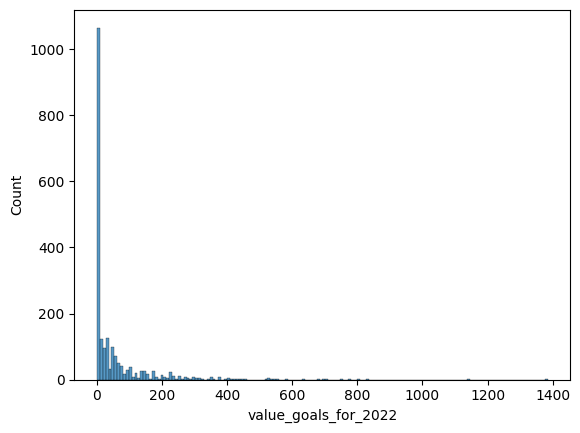

In [ ]:
sns.histplot(df_cleaned["value_goals_for_2022"])

In [ ]:
df_cleaned.to_pickle('attackers_more_features_df.pkl')

In [ ]:
df_cleaned.columns

Index(['player_id', 'games_2022', 'minutes_played_2022', 'goals_2022',
       'assists_2022', 'goals_against_2022', 'goals_for_2022',
       'clean_sheet_2022', 'name', 'position', 'sub_position', 'last_season',
       'foot', 'height_in_cm', 'age', 'country_of_citizenship',
       'country_of_birth', 'current_club_name', 'club_value', 'squad_size',
       'current_club_domestic_competition_id', 'agent_name',
       'contract_expiration_date', 'term_days_remaining',
       'market_value_in_eur', 'highest_market_value_in_eur',
       'value_goals_for_2022', 'value_goals_against_2022',
       'value_clean_sheet_2022', 'yellow_cards_2022', 'red_cards_2022'],
      dtype='object')

In [ ]:
df_cleaned.groupby(['current_club_domestic_competition_id'])

In [ ]:
competitions = df_cleaned.current_club_domestic_competition_id.unique()

In [ ]:
clubs_by_competition = {}
for competition in competitions:
    clubs_by_competition[competition] =  list(df_cleaned[df_cleaned['current_club_domestic_competition_id'] == competition]['current_club_name'].unique())



In [ ]:
df_cleaned.groupby('current_club_domestic_competition_id')['club_value'].mean()

current_club_domestic_competition_id
BE1      8.0
DK1      5.0
ES1     34.0
FR1     75.0
GB1     58.0
GR1      4.0
IT1     44.0
L1      22.0
NL1      8.0
PO1     26.0
RU1      9.0
SC1      5.0
TR1     50.0
UKR1     3.0
Name: club_value, dtype: float64

In [ ]:
df_cleaned.club_value

21969    9.0
21970    8.0
21971    9.0
21972    9.0
21973    8.0
        ... 
28467    8.0
28468    8.0
28469    8.0
28472    8.0
28487    8.0
Name: club_value, Length: 2087, dtype: float64